#### Importing Required Libraries

In [2]:
from keras.models import Model # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.layers import Dense,BatchNormalization,Reshape,Conv2D,Conv3D,Flatten # type: ignore
from keras.layers import Dropout,Input # type: ignore
from keras.callbacks import ModelCheckpoint # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from keras.optimizers.schedules import ExponentialDecay # type: ignore

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,KernelPCA
from sklearn.metrics import confusion_matrix,cohen_kappa_score,classification_report,accuracy_score

from operator import truediv
from plotly.offline import init_notebook_mode
from scipy.io import loadmat
 
import numpy as np
import spectral
import matplotlib.pyplot as plt
import seaborn as sns

init_notebook_mode(connected=True)
%matplotlib inline

#### Parameters and Data Loading

In [3]:
test_ratio=0.7
window_size=25

def LoadData():
    HSI=loadmat(r"Dataset\Indian_pines_corrected.mat")["indian_pines_corrected"]
    ground_truth=loadmat(r"Dataset\Indian_pines_gt.mat")["indian_pines_gt"]
    return HSI,ground_truth

def TrainTestDistribution(X,Y,test_ratio,random_state=345):
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=test_ratio,random_state=random_state,stratify=Y)
    return X_train,X_test,Y_train,Y_test

In [4]:
X,Y=LoadData()
print("Hyperspectral image shape: ",X.shape)
print("Ground truth shape: ",Y.shape)

Hyperspectral image shape:  (145, 145, 200)
Ground truth shape:  (145, 145)


#### PCA and Padding the HSI

In [5]:
def PrincipalComponentAnalysis(X,n_components):
    X_new=np.reshape(X,(-1,X.shape[2]))
    pca=PCA(n_components=n_components,whiten=True)
    X_new=pca.fit_transform(X_new)
    X_new=np.reshape(X_new,(X.shape[0],X.shape[1],n_components))
    return X_new,pca

def Padding(X,margin=2):
    X_new=np.zeros((X.shape[0]+2*margin,X.shape[1]+2*margin,X.shape[2]))
    X_offset=margin
    Y_offset=margin
    X_new[X_offset:X.shape[0]+X_offset,Y_offset:X.shape[1]+Y_offset,:]=X
    return X_new

In [6]:
n_components=50
X,pca=PrincipalComponentAnalysis(X,n_components=n_components)
print("Hyperspectral image after PCA shape: ",X.shape)

Hyperspectral image after PCA shape:  (145, 145, 50)


#### Patch Extarction

In [7]:
def PatchExtarction(X,Y,window_size=5,remove_zero_labels=True):
    margin=int((window_size-1)/2)
    X_padded=Padding(X,margin=margin)
    Data_patch=np.zeros((X.shape[0]*X.shape[1],window_size,window_size,X.shape[2]))
    Label_patch=np.zeros((X.shape[0]*X.shape[1]))
    Patch_index=0
    for row in range(margin,X_padded.shape[0]-margin):
        for col in range(margin,X_padded.shape[1]-margin):
            patch=X_padded[row-margin:row+margin+1,col-margin:col+margin+1]
            Data_patch[Patch_index,:,:,:]=patch
            Label_patch[Patch_index]=Y[row-margin,col-margin]
            Patch_index+=1
    if remove_zero_labels:
        Data_patch=Data_patch[Label_patch>0,:,:,:]
        Label_patch=Label_patch[Label_patch>0]
        Label_patch-=1
    return Data_patch,Label_patch

In [8]:
X,Y=PatchExtarction(X,Y,window_size=window_size)
print("Hyperspectral image shape: ",X.shape)
print("Ground truth shape: ",Y.shape)

X_train,X_test,Y_train,Y_test=TrainTestDistribution(X,Y,test_ratio)
print("HSI training set shape: ",X_train.shape)
print("HSI testing set shape: ",X_test.shape)
print("Ground truth training set shape: ",Y_train.shape)
print("Ground truth testing set shape: ",Y_test.shape)

X_train=X_train.reshape(-1,window_size,window_size,n_components,1)
print("Reshaped HSI training set shape",X_train.shape)

Y_train=to_categorical(Y_train)
print("Ground truth training set shape after one-hot encoding:", Y_train.shape)

Hyperspectral image shape:  (10249, 25, 25, 50)
Ground truth shape:  (10249,)
HSI training set shape:  (3074, 25, 25, 50)
HSI testing set shape:  (7175, 25, 25, 50)
Ground truth training set shape:  (3074,)
Ground truth testing set shape:  (7175,)
Reshaped HSI training set shape (3074, 25, 25, 50, 1)
Ground truth training set shape after one-hot encoding: (3074, 16)


#### 3D CNN Model

In [9]:
output_units=16

# Input Layer
input_layer=Input((window_size,window_size,n_components,1))

# Convolution Layers
conv_layer1=Conv3D(filters=8,kernel_size=(3,3,7),activation='relu')(input_layer)
conv_layer2=Conv3D(filters=16,kernel_size=(3,3,5),activation='relu')(conv_layer1)
conv_layer3=Conv3D(filters=32,kernel_size=(3,3,3),activation='relu')(conv_layer2)
print("Convolution Layer 3 shape",conv_layer3.shape)
conv3d_shape=conv_layer3.shape
conv_layer3=Reshape((conv3d_shape[1],conv3d_shape[2],conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4=Conv2D(filters=64,kernel_size=(3,3),activation='relu')(conv_layer3)

flatten_layer=Flatten()(conv_layer4)

# Fully connected Layers
dense_layer1=Dense(units=256,activation='relu')(flatten_layer)
dense_layer1=Dropout(0.4)(dense_layer1)
dense_layer2=Dense(units=128,activation='relu')(dense_layer1)
dense_layer2=Dropout(0.4)(dense_layer2)
output_layer=Dense(units=output_units,activation='softmax')(dense_layer2)

Convolution Layer 3 shape (None, 19, 19, 38, 32)


In [10]:
model=Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 25, 50, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 23, 23, 44, 8)  │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 21, 21, 40, 16) │         5,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 19, 19, 38, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 1216)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 17, 17, 64)     │       700,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,490,816 (20.95 MB)

 Trainable params: 5,490,816 (20.95 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
adam=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

#### Model Checkpoint and Training

In [12]:
filepath=r"Model\3DCNN_model.keras"
checkpoint=ModelCheckpoint(filepath,monitor='acc',verbose=1,save_best_only=True,mode='max')
callbacks=[checkpoint]

In [13]:
history=model.fit(x=X_train,y=Y_train,batch_size=256,epochs=25,callbacks=callbacks)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 855ms/step - accuracy: 0.1106 - loss: 2.8900
Epoch 2/25


c:\Users\adith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning:

Can save best model only with acc available, skipping.



13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 787ms/step - accuracy: 0.1987 - loss: 2.4813
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.2267 - loss: 2.4348
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3179 - loss: 2.1990
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 761ms/step - accuracy: 0.3363 - loss: 2.0081
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 788ms/step - accuracy: 0.3522 - loss: 1.8376
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 772ms/step - accuracy: 0.4272 - loss: 1.5888
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 780ms/step - accuracy: 0.5784 - loss: 1.3398
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 794ms/step - accuracy: 0.6740 - loss: 0.9521
Epoch 10/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7883 - loss: 0.6147
Epoch 11/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8531 - loss: 0.4796
Epoch 12/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 783ms/step - accuracy: 0.8977 - loss: 0.2919
Epoch 13/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 792ms/step - accurac

#### Loss and Accuracy

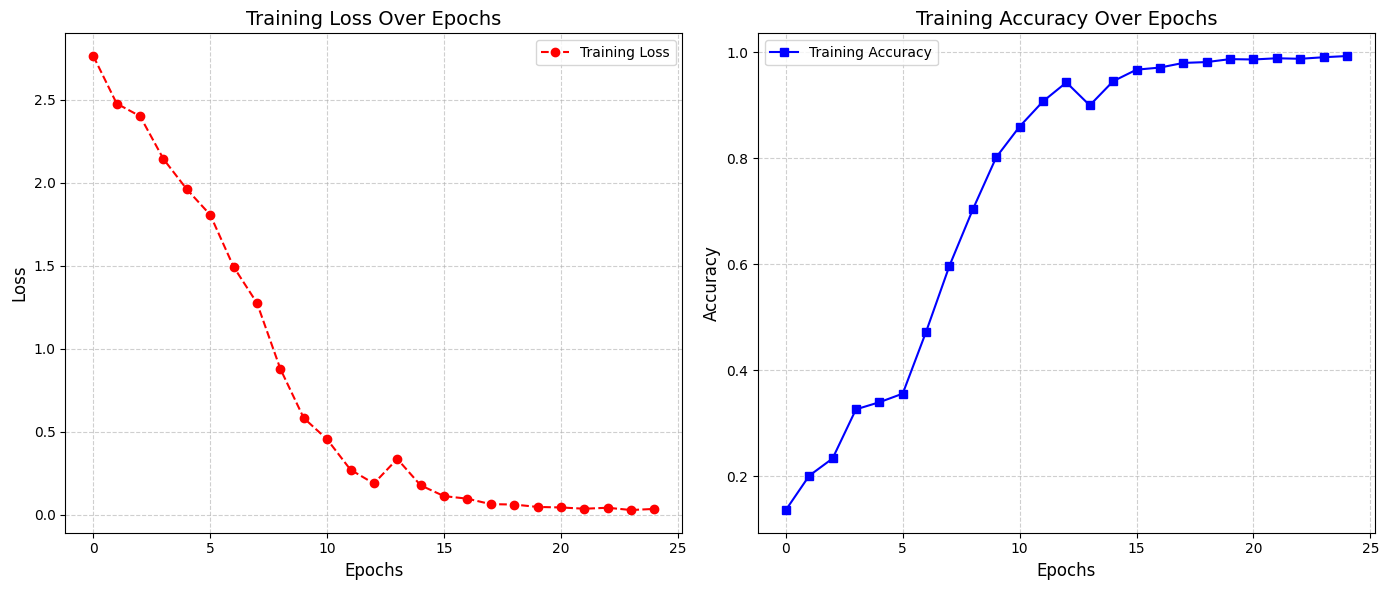

In [14]:
fig,axes=plt.subplots(1,2,figsize=(14,6))

axes[0].plot(history.history['loss'],label='Training Loss',color='red',linestyle='--',marker='o')
axes[0].set_title('Training Loss Over Epochs',fontsize=14)
axes[0].set_xlabel('Epochs',fontsize=12)
axes[0].set_ylabel('Loss',fontsize=12)
axes[0].grid(True,linestyle='--',alpha=0.6)
axes[0].legend()

axes[1].plot(history.history['accuracy'],label='Training Accuracy',color='blue',linestyle='-',marker='s')
axes[1].set_title('Training Accuracy Over Epochs',fontsize=14)
axes[1].set_xlabel('Epochs',fontsize=12)
axes[1].set_ylabel('Accuracy',fontsize=12)
axes[1].grid(True,linestyle='--',alpha=0.6)
axes[1].legend()

plt.tight_layout()
plt.show()

#### Classification Report

In [15]:
X_test=X_test.reshape(-1,window_size,window_size,n_components,1)
print("Reshaped HSI training set shape",X_test.shape)

Y_test=to_categorical(Y_test)
print("Ground truth training set shape after one-hot encoding:", Y_train.shape)

Y_predicted=model.predict(X_test)
Y_predicted=np.argmax(Y_predicted,axis=1)
classification=classification_report(np.argmax(Y_test,axis=1),Y_predicted)
print("Classification Report:\n",classification)

Reshaped HSI training set shape (7175, 25, 25, 50, 1)
Ground truth training set shape after one-hot encoding: (3074, 16)
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.99      0.99      0.99      1000
           2       0.99      0.99      0.99       581
           3       0.98      0.99      0.98       166
           4       0.99      0.99      0.99       338
           5       0.99      0.97      0.98       511
           6       1.00      0.90      0.95        20
           7       1.00      1.00      1.00       335
           8       1.00      1.00      1.00        14
           9       0.99      1.00      0.99       680
          10       0.99      0.99      0.99      1719
          11       0.99      1.00      0.99       415
          12       1.00      0.99      1.00       143
          13       1.00      1.00      1.00       886
 

#### Accuracy and IOU

In [16]:
def Accuracy(confusion_matrix):
    diagonal=np.diag(confusion_matrix)
    raw_sum=np.sum(confusion_matrix,axis=1)
    per_class_accuracy=np.nan_to_num(truediv(diagonal,raw_sum))
    average_accuracy=np.mean(per_class_accuracy)
    return per_class_accuracy,average_accuracy

In [17]:
def IOU(confusion_matrix):
    per_class_IOU=[]
    for i in range(confusion_matrix.shape[0]):
        True_positive=confusion_matrix[i,i]
        False_positive=sum(confusion_matrix[:,i])-True_positive
        False_negative=sum(confusion_matrix[i,:])-True_positive
        denominator=True_positive+False_positive+False_negative
        IOU=True_positive/denominator if denominator !=0 else 0
        per_class_IOU.append(IOU)
    
    mean=np.mean(per_class_IOU) 
    return per_class_IOU,mean

#### Classification Report

225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.9921 - loss: 0.0268
Accuracy: 99.21%
Kappa Coefficient: 0.9909
Average Accuracy: 98.46%
Overall Accuracy: 99.21%
Mean IoU: 0.9778

Per-Class IoU:

Alfalfa: 0.9688
Corn-notill: 0.9821
Corn-mintill: 0.9847
Corn: 0.9647
Grass-pasture: 0.9766
Grass-trees: 0.9630
Grass-pasture-mowed: 0.9000
Hay-windrowed: 1.0000
Oats: 1.0000
Soybean-notill: 0.9884
Soybean-mintill: 0.9845
Soybean-clean: 0.9880
Wheat: 0.9930
Woods: 0.9955
Buildings-Grass-Trees-Drives: 0.9853
Stone-Steel-Towers: 0.9697


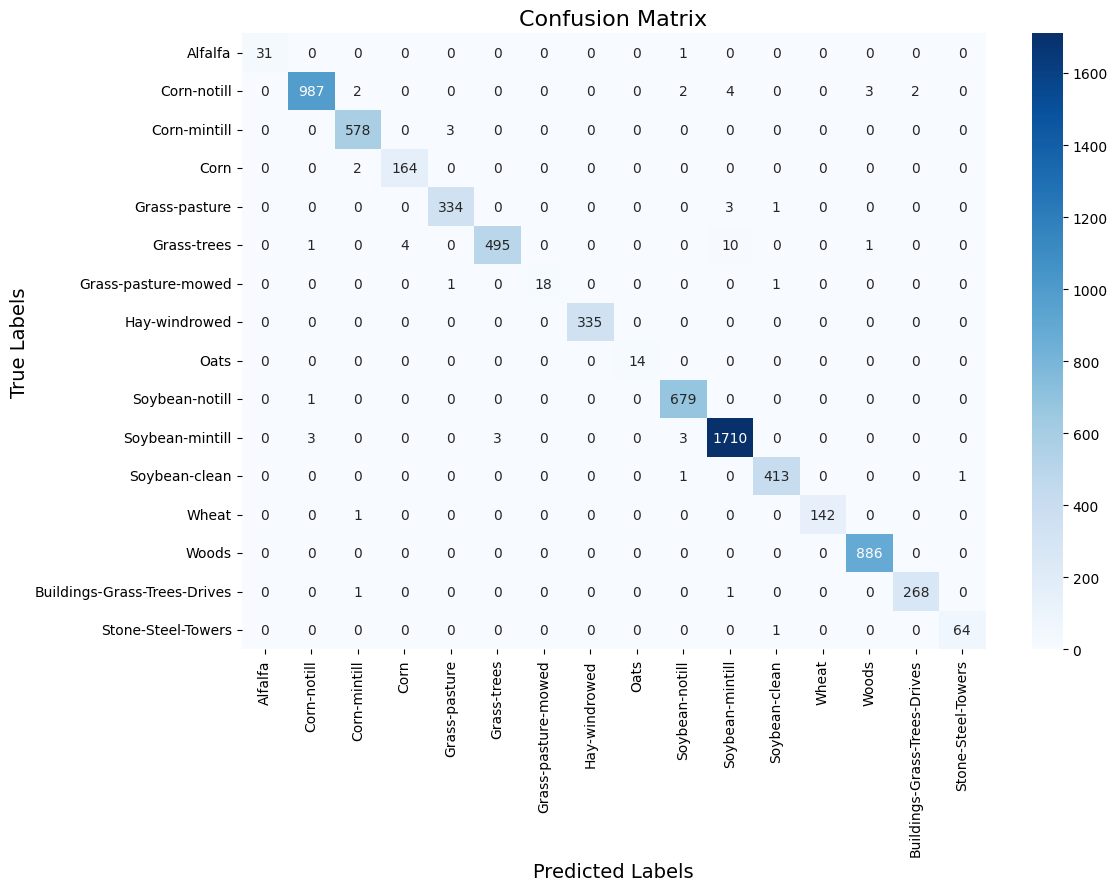

In [18]:
def reports(X_test,Y_test):
    Y_predicted=model.predict(X_test)
    Y_predicted=np.argmax(Y_predicted,axis=1)
    target_names=['Alfalfa','Corn-notill','Corn-mintill','Corn','Grass-pasture',
                'Grass-trees','Grass-pasture-mowed','Hay-windrowed','Oats',
                'Soybean-notill','Soybean-mintill','Soybean-clean','Wheat',
                'Woods','Buildings-Grass-Trees-Drives','Stone-Steel-Towers']
    accuracy=accuracy_score(np.argmax(Y_test,axis=1),Y_predicted)
    confusion=confusion_matrix(np.argmax(Y_test,axis=1),Y_predicted)
    _,average=Accuracy(confusion)
    kappa=cohen_kappa_score(np.argmax(Y_test,axis=1),Y_predicted)
    per_class_IOU,mean=IOU(confusion)
    score=model.evaluate(X_test,Y_test,batch_size=32)
    Test_accuracy=score[1]*100
    
    print(f'Accuracy: {Test_accuracy:.2f}%')
    print(f'Kappa Coefficient: {kappa:.4f}')
    print(f'Average Accuracy: {average*100:.2f}%')
    print(f'Overall Accuracy: {accuracy*100:.2f}%')
    print(f'Mean IoU: {mean:.4f}')
    
    print("\nPer-Class IoU:\n")
    for i,target in enumerate(target_names):
        print(f'{target}: {per_class_IOU[i]:.4f}')
    
    plt.figure(figsize=(12,8))
    sns.heatmap(confusion,annot=True,fmt="d",cmap="Blues",xticklabels=target_names,yticklabels=target_names)
    
    plt.xlabel("Predicted Labels",fontsize=14)
    plt.ylabel("True Labels",fontsize=14)
    plt.title("Confusion Matrix",fontsize=16)
    plt.xticks(rotation=90) 
    plt.yticks(rotation=0)

reports(X_test,Y_test)


#### Predicted image and Ground truth

In [19]:
X,Y=LoadData()

height=Y.shape[0]
width=Y.shape[1]
Patch_Size=window_size
print("Height:",height)
print("Width:",width)

X,pca=PrincipalComponentAnalysis(X,n_components=n_components)
X=Padding(X,Patch_Size//2)

Height: 145
Width: 145


In [20]:
def Patch(data,height_index,width_index):
    height_slice=slice(height_index,height_index+Patch_Size)
    width_slice=slice(width_index,width_index+Patch_Size)
    patch=data[height_slice,width_slice,:]
    return patch

In [21]:
outputs=np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target=int(Y[i,j])
        if target==0:
            continue
        else:
            image_patch=Patch(X,i,j)
            X_test_image=image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1],image_patch.shape[2],1).astype('float32')                                   
            prediction=(model.predict(X_test_image))
            prediction=np.argmax(prediction,axis=1)
            outputs[i][j]=prediction+1
print("Shape:",outputs.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


C:\Users\adith\AppData\Local\Temp\ipykernel_7744\903375767.py:12: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

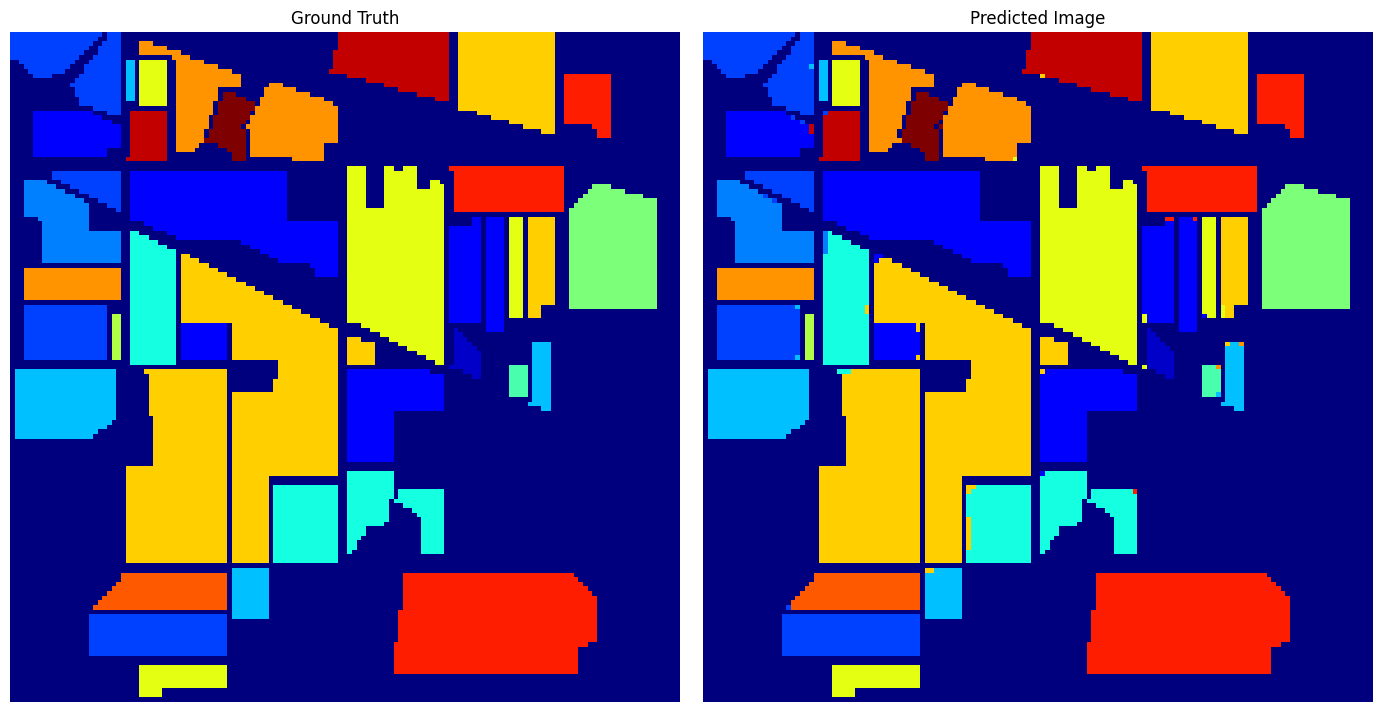

In [22]:
_,axes=plt.subplots(1,2,figsize=(14,7))

axes[0].imshow(Y,cmap='jet')
axes[0].set_title("Ground Truth")
axes[0].axis('off')

axes[1].imshow(outputs.astype(int),cmap='jet')
axes[1].set_title("Predicted Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()